### 0. Install all the necessary libraries 

In [1]:
# Upgrade the notebook
%pip install --upgrade notebook

# Install TensorFlow (includes GPU support)
%pip install tensorflow

# Install OpenCV for image processing tasks and remove not to be trusted images
%pip install opencv-python

# Install Matplotlib for visualizing images
%pip install matplotlib


   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   - -------------------------------------- 0.2/4.0 MB 4.5 MB/s eta 0:00:01
   ---- ----------------------------------- 0.5/4.0 MB 6.2 MB/s eta 0:00:01
   ----------- ---------------------------- 1.1/4.0 MB 8.0 MB/s eta 0:00:01
   --------------- ------------------------ 1.6/4.0 MB 9.2 MB/s eta 0:00:01
   --------------- ------------------------ 1.6/4.0 MB 9.2 MB/s eta 0:00:01
   ----------------------- ---------------- 2.3/4.0 MB 9.3 MB/s eta 0:00:01
   ----------------------------- ---------- 3.0/4.0 MB 9.6 MB/s eta 0:00:01
   ---------------------------------- ----- 3.4/4.0 MB 9.5 MB/s eta 0:00:01
   -------------------------------------- - 3.9/4.0 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------- 4.0/4.0 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: notebook
    Found existing installation: notebook 7.0.6
    Uninstalling notebook-7.0.6:
      Successfully uninstalled notebook-7.0.6
Note: you m

**1. Remove all of the not trusted images**

In [3]:
# Import some Dependencies

# TensorFlow: for building and running the neural network models
import tensorflow as tf 
# OS module: for interacting with the operating system, particularly useful for file and directory paths
import os 
# Image loading and preprocessing
import cv2


# Directory containing the dataset
data_dir = 'Data'

# Iterate through each class/category in the dataset
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    # Check if the path is a directory to avoid processing non-directory files
    if not os.path.isdir(class_path):
        continue  # Skip any non-directory files

    # Iterate through each image in the current class/category directory
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)

        # Attempt to process and verify each image
        try:
            # Read the image using OpenCV
            img = cv2.imread(image_path)

            # Check if the image is valid (non-empty)
            if img is None:
                print(f'Invalid or corrupted image: {image_path}')
                os.remove(image_path)

        # Catch and report any errors encountered during the image processing
        except Exception as e:
            print(f'Issue with image {image_path}: {e}')


**Learning Rate Scheduler**

In [42]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
    """
    This function adjusts the learning rate during training.
    Returns:
    The new learning rate for the next round of training.
    """
    # Keep the same learning rate for the first 10 epochs
    if epoch < 10:
        return lr
    else:
        # Reduce the learning rate starting from the 11th epoch
        return lr * tf.math.exp(-0.1)

# Set up the scheduler as a callback for training.
# This tells the training process to use our scheduler function to adjust the learning rate.
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


**2. Split load work with data**

Found 1030 files belonging to 2 classes.
Found 1030 files in 2 categories.
Found 1030 images belonging to 2 classes.


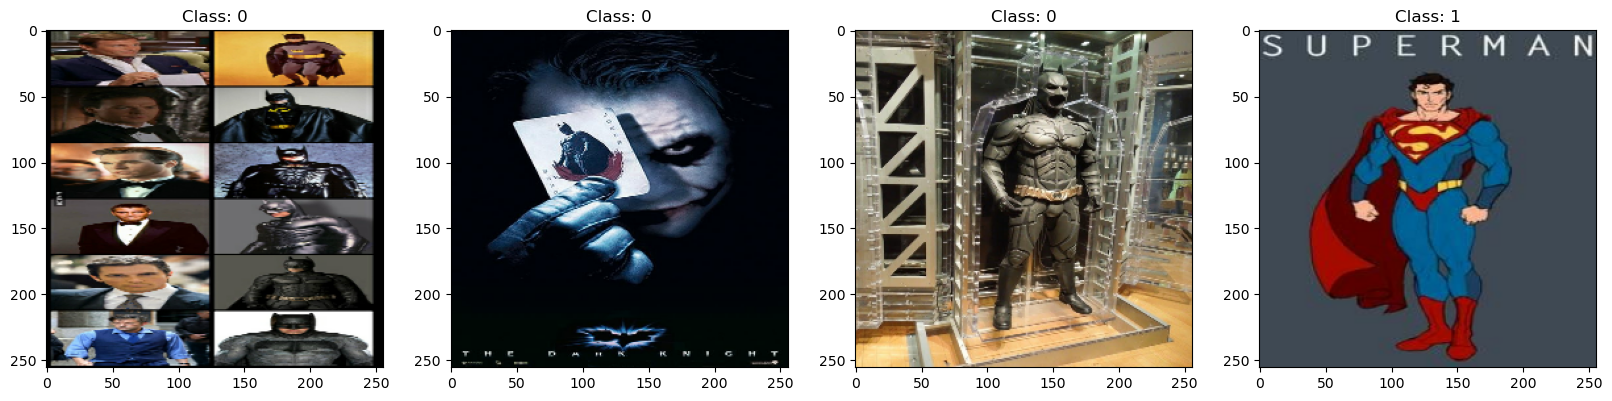

Got it sorted: Training Size - 23, Validation Size - 6, Test Size - 3


In [43]:
# Import some Dependencies
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Just a reminder Badr to make sure I have the right path
# Here's where my image data is stored.
data_dir = 'data'
train_dir = 'C:\\Users\\zouha\\Downloads\\Image_Classifier\\Data'

# This line loads up my images and sorts them into classes based on folder names.
data = tf.keras.utils.image_dataset_from_directory(data_dir)
print(f'Found {len(data.file_paths)} files in {len(data.class_names)} categories.')

# Setting up data augmentation to make my model more robust. 
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preparing the training data with the augmentations
train_generator = augmentation.flow_from_directory(
    train_dir,  # Pointing to where my training data is.
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

# Making sure all my image data is on the same scale - this makes the model work better.
data = data.map(lambda x, y: (x / 255.0, y)).prefetch(tf.data.AUTOTUNE)

# Converting the data into a format Python can easily work with.
data_iterator = data.as_numpy_iterator()

# Grabbing a batch of images and their labels for a quick check.
try:
    batch = data_iterator.next()
except Exception as e:
    print(f'Oops, something went wrong: {e}')
    exit()

# Showing off a few of my images to make sure everything looks right.
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):  # Going through the first four images
    # Adjusting the image scale for display
    img_to_display = (img * 255).astype('uint8') if img.max() <= 1.0 else img.astype('uint8')
    ax[idx].imshow(img_to_display)
    ax[idx].title.set_text(f'Class: {batch[1][idx]}')  # Labeling with the correct class
plt.show()

# Time to split the data into training, validation, and testing sets.
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

# Creating the subsets for different phases of model training.
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Double-checking my dataset sizes to make sure everything adds up.
print(f'Got it sorted: Training Size - {train_size}, Validation Size - {val_size}, Test Size - {test_size}')


**3. Model Definition and Setup**

In [44]:
# Import some Dependencies
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import     
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# Custom Layer for more complex feature extraction
@tf.keras.utils.register_keras_serializable()
class MyCustomLayer(Layer):
    # Initialize with units, similar to neurons in a dense layer
    def __init__(self, units=32, **kwargs):
        super(MyCustomLayer, self).__init__(**kwargs)
        self.units = units

    # Weights and biases for the custom layer
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    # How the layer transforms the input
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

# Setting up the CNN architecture
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())  # Flattening to switch from 2D to 1D data
model.add(MyCustomLayer(256))  # Our custom layer in action
model.add(Dropout(0.5))  # To prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # Final output layer

# Callbacks to optimize training
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join('models', 'model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.keras'),
    save_best_only=True, 
    monitor='val_loss',
    mode='min'
)

# Compile model with optimizer, loss function, and metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


**4. Training, Evaluation, and Visualization**

Found 1030 images belonging to 2 classes.
Epoch 1/10
17/17 [==============================] - 65s 4s/step - loss: 498.9012 - accuracy: 0.5204 - val_loss: 0.7523 - val_accuracy: 0.5833
Epoch 2/10
17/17 [==============================] - 62s 4s/step - loss: 212.5577 - accuracy: 0.5922 - val_loss: 0.9749 - val_accuracy: 0.6146
Epoch 3/10
17/17 [==============================] - 62s 4s/step - loss: 181.0686 - accuracy: 0.6078 - val_loss: 0.9537 - val_accuracy: 0.6146
Epoch 4/10
17/17 [==============================] - 64s 4s/step - loss: 216.2715 - accuracy: 0.6146 - val_loss: 0.7103 - val_accuracy: 0.6979
Epoch 5/10
17/17 [==============================] - 64s 4s/step - loss: 140.3371 - accuracy: 0.6563 - val_loss: 0.5649 - val_accuracy: 0.7708
Epoch 6/10
17/17 [==============================] - 64s 4s/step - loss: 141.5782 - accuracy: 0.6408 - val_loss: 1.1839 - val_accuracy: 0.5625
Epoch 7/10
17/17 [==============================] - 63s 4s/step - loss: 105.9484 - accuracy: 0.6777 - val_

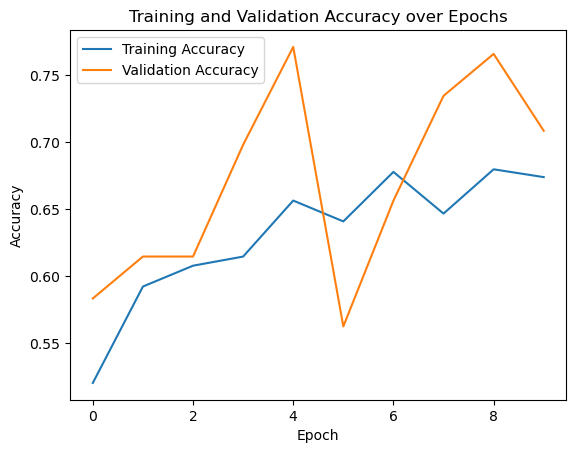

1/1 [==============================] - 0s 104ms/step
Precision: 0.9200000166893005
Recall: 0.45098039507865906
Accuracy: 0.6875


In [45]:
    # Import some Dependencies
    from matplotlib import pyplot as plt
    from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    # Data augmentation for more robust learning
    augmentation = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    train_generator = augmentation.flow_from_directory(
        'C:\\Users\\zouha\\Downloads\\Image_Classifier\\Data',  # Training data path
        target_size=(256, 256),
        batch_size=64,
        class_mode='binary'
    )

    # Match the data size
    steps_per_epoch = len(train_generator.filenames) // train_generator.batch_size

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model with the adjusted learning rate
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=10,
        validation_data=val,
        callbacks=[tensorboard_callback, early_stopping, model_checkpoint]
    )
    # Saving the trained model for later use
    model.save(os.path.join('models', 'imageclassifier.keras'))

    # Visualizing training and validation accuracy
    plt.figure()
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Model performance metrics on the test set
    precision_metric = Precision()
    recall_metric = Recall()
    accuracy_metric = BinaryAccuracy()
    threshold = 0.5  # Decision boundary for binary classification

    # Evaluating precision, recall, and accuracy
    for batch in test.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X)
        yhat_binary = (yhat > threshold).astype(int)
        precision_metric.update_state(y, yhat_binary)
        recall_metric.update_state(y, yhat_binary)
        accuracy_metric.update_state(y, yhat_binary)

    # Outputting the evaluated metrics
    print(f'Precision: {precision_metric.result().numpy()}')
    print(f'Recall: {recall_metric.result().numpy()}')
    print(f'Accuracy: {accuracy_metric.result().numpy()}')

    # Load the model for further testing or prediction
    new_model = tf.keras.models.load_model('models/imageclassifier.keras', custom_objects={'MyCustomLayer': MyCustomLayer})


**5. Test the model**

In [48]:
# Import some Dependencies
import tkinter as tk # for GUI application
from tkinter import filedialog, messagebox
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image, ImageTk

# Load the AI model that can differentiate between Superman and Batman.
model = tf.keras.models.load_model('models/imageclassifier.keras')

# Function to predict whether the image is of Superman or Batman.
def predict_image(image_path):
    img = cv2.imread(image_path)  # Load the image from the given path.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistency.
    resize = tf.image.resize(img_rgb, (256, 256))  # Resize to the size model expects.
    yhat = model.predict(np.expand_dims(resize / 255, 0))  # Predict and normalize the image.
    return 'Superman' if yhat > 0.5 else 'Batman'  # Decide the class based on the prediction.

# Function to handle the upload button action.
def upload_action():
    file_path = filedialog.askopenfilename()  # Open a dialog to select an image.
    if file_path:  # Check if a file was selected.
        try:
            prediction = predict_image(file_path)  # Make a prediction.
            label_prediction.config(text=f'Prediction: {prediction}')  # Update the label with the prediction.
            display_image(file_path)  # Show the image on the GUI.
            status_bar.config(text='Image loaded and prediction made.')  # Update the status.
        except Exception as e:
            messagebox.showerror('Error', 'Failed to process the image.')  # Show error if any.

# Function to display the selected image in the GUI.
def display_image(image_path):
    try:
        img = Image.open(image_path)  # Open the image.
        img = img.resize((250, 250), Image.BILINEAR)  # Resize for display.
        img_tk = ImageTk.PhotoImage(img)  # Convert to a format Tkinter can use.
        panel.config(image=img_tk)  # Update the panel to show the image.
        panel.image = img_tk  # Avoid the image being garbage collected.
    except Exception as e:
        print(f"Error: {e}")  # Print any errors.
        messagebox.showerror('Error', f'Failed to display the image. Error: {e}')  # Show error to user.

# Set up the main window.
root = tk.Tk()
root.title("Superman or Batman Classifier")  # Window title.
root.geometry('300x400')  # Window size: 300 pixels wide and 400 pixels tall.

# Button to upload an image.
btn_upload = tk.Button(root, text='Upload Image', command=upload_action, font=('Helvetica', 10))
btn_upload.pack(pady=10)

# Label to show the prediction result.
label_prediction = tk.Label(root, text='Prediction: None', font=('Helvetica', 12), bg='white', fg='black')
label_prediction.pack(pady=10)

# Panel to display the uploaded image.
panel = tk.Label(root, bg='gray')
panel.pack(padx=10, pady=10, fill='both', expand=True)

# Status bar to show the current status at the bottom of the window.
status_bar = tk.Label(root, text='Ready', bd=1, relief='sunken', anchor='w')
status_bar.pack(side='bottom', fill='x')

# Run the GUI application.
root.mainloop()


1/1 [==============================] - 0s 43ms/step
